# Goals
    - Measure the roasted coffee's quality  based on the temperature in celsius and duration in minutes

In [1]:
import numpy as np
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Problem Statement
We aim to provide insights into the relationship between the predictor variables and the performance index. We will use this dataset to explore the impact of temperature and duration of the roasting on coffee's quality.

#### Variables:
- Temperature: in celsius.
- Duration: in minutes.

#### Target Variable:
- Quality: A measure of the coffee's quality of each experience. 1 for a good quality and 0 for a bad one.

# Display Data

In [2]:
df = pd.read_csv('data/roasting_coffee_data.csv')

In [3]:
# Describe the columns
print(df.columns)
# Check for null values
df.isnull().sum()

Index(['temperature', 'duration', 'quality'], dtype='object')


temperature    0
duration       0
quality        0
dtype: int64

In [4]:
# Check for duplicated values
df.duplicated().sum()

0

In [5]:
# Separate the independent variables (features)
X_train = np.array(df[['temperature', 'duration']])
# Separate the dependent variable (target)
y_train = np.array(df['quality'])

In [6]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")

X Shape: (200, 2), X Type:<class 'numpy.ndarray'>)
y Shape: (200,), y Type:<class 'numpy.ndarray'>)


In [7]:
def display_data(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=50, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='.',  label="Bad Roast")
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

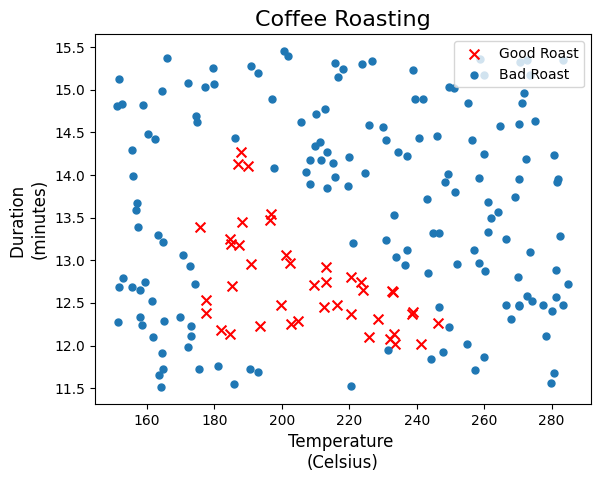

In [8]:
display_data(X_train, y_train)

# Normalize Data

In [9]:
print(f"Temperature Max, Min pre normalization: {np.max(X_train[:,0])}, {np.min(X_train[:,0])}")
print(f"Duration    Max, Min pre normalization: {np.max(X_train[:,1])}, {np.min(X_train[:,1])}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X_train)  # learns mean, variance
Xn = norm_l(X_train)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.3f}, {np.min(Xn[:,0]):0.3f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.3f}, {np.min(Xn[:,1]):0.3f}")

Temperature Max, Min pre normalization: 284.994, 151.324
Duration    Max, Min pre normalization: 15.454, 11.513
Temperature Max, Min post normalization: 1.660, -1.685
Duration    Max, Min post normalization: 1.793, -1.699


In [10]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(y_train,(1000,1)) 
Yt = Yt.reshape(-1,1)
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


## Part One : Using Tensorflow

In [11]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')

    ]
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [13]:
W1, b1 = model.get_layer("layer1").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)

W2, b2 = model.get_layer("layer2").get_weights()
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.07 -0.8  -1.04]
 [-0.59  1.03  0.1 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.95]
 [-0.18]
 [-1.19]] 
b2(1,): [0.]


In [14]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.1740
Epoch 2/10
6250/6250 [==============================] - 6s 981us/step - loss: 0.0508
Epoch 3/10
6250/6250 [==============================] - 6s 972us/step - loss: 0.0224
Epoch 4/10
6250/6250 [==============================] - 6s 963us/step - loss: 0.0138
Epoch 5/10
6250/6250 [==============================] - 6s 985us/step - loss: 0.0085
Epoch 6/10
6250/6250 [==============================] - 6s 999us/step - loss: 0.0051
Epoch 7/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0030
Epoch 8/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0017
Epoch 9/10
6250/6250 [==============================] - 6s 1ms/step - loss: 9.9945e-04
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step - loss: 6.1510e-04


### After fitting, the weights have been updated: 

In [15]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ -0.74  16.28 -13.04]
 [-13.14  13.51  -0.29]] 
b1: [-16.88   2.11 -14.3 ]
W2:
 [[-60.41]
 [-53.52]
 [-51.66]] 
b2: [26.18]


### Prediction

In [16]:
def predict(X):
    X_n = norm_l(X)
    predictions = model.predict(X_n)
    y_hat = np.zeros_like(predictions)
    for i in range(len(predictions)):
        y_hat[i] = (predictions[i]>0.5).astype(int)
    return y_hat

In [17]:
X_test = np.array([
    [200,13.9],  # positive example
    [200,17]])   # negative example
print(predict(X_test))

1/1 [==============================] - 0s 65ms/step
[[0.]
 [0.]]


### Part Two : Using Numpy (Forward Prop in NumPy)

In [18]:
def sigmoid(z):
    return (1/(1+np.exp(-z)))

Define the `dense()` function which computes the activations of a dense layer.

In [19]:
def dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
    Returns
      a_out (ndarray (j,))  : j units|
      """
    n,j = W.shape
    a_out = np.zeros(j)
    for i in range(j):
        a_out[i] = g(np.dot(a_in, W[:,i]) + b[i])
    return a_out

The following cell builds a two-layer neural network utilizing the `dense` subroutine above.

In [20]:
def sequential_model(x,W1,b1,W2,b2,g):
    a_out_1 = dense(x,W1,b1,g)
    a_out_2 = dense(a_out_1,W2,b2,g)
    return a_out_2

In [21]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

Implementing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ examples in the rows and make a prediction by running the model.

In [22]:
def predict(X, W1, b1, W2, b2,g):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = sequential_model(X[i], W1, b1, W2, b2,g)
    return(p)

In [23]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
pr = predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp, sigmoid)
pr = (pr>0.5).astype(int)
print(pr)

[[1]
 [0]]


C:\Users\Mehrez\AppData\Local\Temp\ipykernel_11788\3729735029.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = sequential_model(X[i], W1, b1, W2, b2,g)


### Part Three : Using Numpy and Vectorization (Forward Prop in NumPy)

In [24]:
def dense_vect(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
    Returns
      a_out (ndarray (j,))  : j units|
      """
    n,j = W.shape
    a_out = np.zeros(j)
    z = np.matmul(a_in,W) + b
    a_out = g(z)
    return a_out

In [25]:
def sequential_model_vect(x,W1,b1,W2,b2,g):
    a_out_1 = dense_vect(x,W1,b1,g)
    a_out_2 = dense_vect(a_out_1,W2,b2,g)
    return a_out_2

In [26]:
def predict_vect(X, W1, b1, W2, b2,g):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = sequential_model_vect(X[i], W1, b1, W2, b2,g)
    return(p)

In [27]:
pr = predict_vect(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp, sigmoid)
pr = (pr>0.5).astype(int)
print(pr)

[[1]
 [0]]


C:\Users\Mehrez\AppData\Local\Temp\ipykernel_11788\649568609.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = sequential_model_vect(X[i], W1, b1, W2, b2,g)
